## Model Evaluation

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

This function claculates **Hopkins Statistics** for the passed data.  
- if the dataset is large, you can pass a subset of it
- the value is near to 1, if the data is not uniformly distributed
- and near to zero, if the data is uniformly distributed
- if H < 0.5, then it is unlikely that data has statistically significant clusters

In [2]:
def hopkins_statistic(data, n_neighbors=10):
    
    # Calculate the number of samples in the dataset
    n = data.shape[0]

    # Generate random points in the same space as the data
    rand_points = np.random.rand(n, data.shape[1])

    # Fit a k-nearest neighbors model to the data
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(data)

    # Calculate the distance between each data point and its nearest neighbor
    data_distances, _ = knn.kneighbors(data)

    # Fit another k-nearest neighbors model to the random points
    knn_rand = NearestNeighbors(n_neighbors=n_neighbors)
    knn_rand.fit(rand_points)

    # Calculate the distance between each random point and its nearest neighbor
    rand_distances, _= knn_rand.kneighbors(rand_points)

    # Calculate the Hopkins statistic
    numerator = np.sum(data_distances)
    denominator = np.sum(data_distances) + np.sum(rand_distances)
    hopkins_stat = numerator / denominator

    print('The dataset has a prob. of', round(hopkins_stat *100, 2), '% of containing a cluster')

In [39]:
df = pd.read_csv('../data/NGC188-result.csv')
df = df[df['parallax'] > 0]
df = df[df['phot_g_mean_mag'] < 18]
df = df[abs(df['pmra']) < 15]
df = df[abs(df['pmdec']) < 15]
df['Gmg'] = df['phot_g_mean_mag'] + (5 * np.log10(abs(df['parallax'])) - 10)

In [40]:
len(df)

2494

In [41]:
newdf = df[['ra','dec','r_est']].dropna(axis=0)

In [43]:
hopkins_statistic(data=newdf, n_neighbors=5)

The dataset has a prob. of 98.92 % of containing a cluster


KeyError: 'phot_g_mean_mag'

### GMM

In [46]:
gm = GaussianMixture(n_components=2, random_state=101)
ypred = gm.fit_predict(df[['pmra', 'pmdec']])
newdf['label'] = ypred
newdf['label'].value_counts()

0    1635
1     859
Name: label, dtype: int64

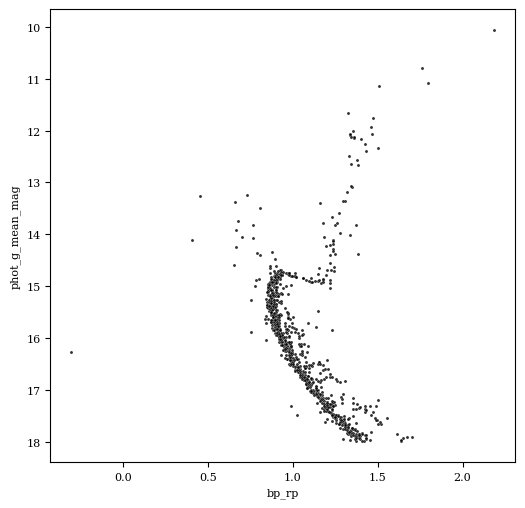

In [73]:
with plt.style.context(['ieee']):
    fig = plt.figure(figsize=(6,6), dpi=100)
    sns.scatterplot(data=df[df['label']==1], y=df['phot_g_mean_mag'], x='bp_rp', alpha=0.8, s=5, )
    plt.gca().invert_yaxis()

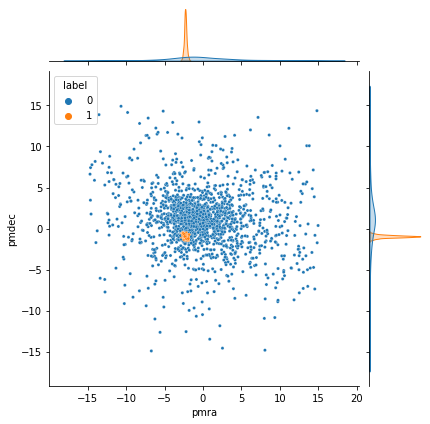

In [55]:
sns.jointplot(
    data=df,
    x="pmra", y="pmdec",
    kind="scatter",
    hue='label',
    s=10
);

### KNN Model

In [104]:
X = newdf.drop('label', axis=1)
y = newdf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

## Confusion Matrix

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       351
           1       0.69      0.81      0.75       148

    accuracy                           0.84       499
   macro avg       0.80      0.83      0.81       499
weighted avg       0.85      0.84      0.84       499



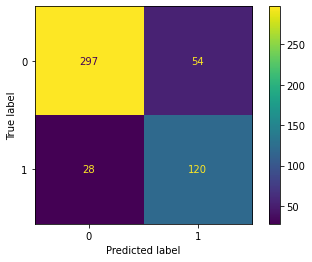

In [105]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
print(classification_report(y_test, y_pred))

### Silhouette Coefficient

In [58]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [106]:
# help(silhouette_score)

In [60]:
silhouette_score(X_test, y_pred, metric='euclidean')

-0.063831770088461